In [932]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [958]:
class RediCell:
    
    def __init__(self, sides=None, spacing=None, t_step=None, molecule_types=None, wall=True):
        # sides in number of voxels
        # spacing in m
        # "wall" adds one extra cell each direction, set as barrier
        self.spacing = spacing
        # Should be a list of Molecule instances
        self.molecule_types = molecule_types
        self.num_types = len(self.molecule_types)
        self.mol_to_id = {mol.molecule_name: idx for idx, mol in enumerate(self.molecule_types)}
        self.id_to_mol = {idx: mol.molecule_name for idx, mol in enumerate(self.molecule_types)}
        self.wall = wall
        self.initialized = False
        self.voxel_matrix = []
        assert len(sides) > 0 and len(sides) < 4
        self.ndim = len(sides)
        self.sides = np.array(sides) # Should be [32, 32] or [32, 32, 32]
        
        if self.wall:
            self.true_sides = self.sides + 2
        else:
            self.true_sides = self.sides

        self.t_step = t_step
        self.action_vector = None
        self.fig = None
        self.cumulative_t = 0
        self.reaction_set = []
        self.num_reaction = len(self.reaction_set)
    
    def partition(self):
        # m, x, y matrix
        self.voxel_matrix = np.zeros((self.num_types, *self.true_sides))

        if self.action_vector is None:
            self.construct_possible_actions()
            print(f'Action vector is {self.action_vector}')
        
        self.action_matrix = np.tile(np.expand_dims(self.action_vector, tuple(range(1, self.ndim+1))), 
                                                   (1, *self.voxel_matrix.shape[1:]))


        if self.wall:
            self.set_border_wall()
        #self.edit_action_vector()

    def set_border_wall(self): 
        self.not_barrier_matrix = np.ones(self.true_sides)
        if self.ndim >= 1:
            self.not_barrier_matrix[0] = 0
            self.not_barrier_matrix[-1] = 0
        if self.ndim >= 2:
            self.not_barrier_matrix[:, 0] = 0
            self.not_barrier_matrix[:, -1] = 0
        if self.ndim >= 3:
            self.not_barrier_matrix[:, :, 0] = 0
            self.not_barrier_matrix[:, :, -1] = 0            
    
    def edit_action_vector(self):
        # Edit action vector
        for x in range(self.true_x):
            for y in range(self.true_y):
                if x == 0: # up
                    self.voxel_matrix[x][y].action_vector[0:4*self.num_types:4] = 0
                if x == self.true_x - 1: # down
                    self.voxel_matrix[x][y].action_vector[1:4*self.num_types:4] = 0
                if y == 0: # left
                    self.voxel_matrix[x][y].action_vector[2:4*self.num_types:4] = 0
                if y == self.true_y - 1: # right
                    self.voxel_matrix[x][y].action_vector[3:4*self.num_types:4] = 0
        for x in range(1, self.true_x - 1):
            for y in range(1, self.true_y - 1):
                if self.voxel_matrix[x-1][y].is_barrier:
                    # print(f'row {x}, column {y}, row above is barrier')
                    self.voxel_matrix[x][y].action_vector[0:4*self.num_types:4] = 0
                if self.voxel_matrix[x+1][y].is_barrier:
                    # print(f'row {x}, column {y}, row below is barrier')
                    self.voxel_matrix[x][y].action_vector[1:4*self.num_types:4] = 0
                if self.voxel_matrix[x][y-1].is_barrier:
                    # print(f'row {x}, column {y}, column to the left is barrier')
                    self.voxel_matrix[x][y].action_vector[2:4*self.num_types:4] = 0
                if self.voxel_matrix[x][y+1].is_barrier:
                    # print(f'row {x}, column {y}, column to the right is barrier')
                    self.voxel_matrix[x][y].action_vector[3:4*self.num_types:4] = 0
        # for x in range(1, self.true_x - 1):
        #     for y in range(1, self.true_y - 1):
        #         print(f'row {x}, column {y}, action_vector {self.voxel_matrix[x][y].action_vector}')
    
    def plot_wall(self):
        plt.imshow(self.not_barrier_matrix, cmap='Oranges_r', vmax=1, vmin=0)
        
    def initialize(self):
        assert self.initialized == False
        # Set condition based on initial conditions
        # Set external conditions
        # Compile all possible reactions (diffuse to 4 neighbors, reactions, and do nothing)
        # Calculate largest possible timestep
        self.initialized = True

    def add_reaction_set(self, reaction_set=None):
        pass
    
    def list_reaction_set(self):
        pass
    
    def construct_possible_actions(self):
        # up, down, left, right for each kind of molecule
        # then reactions
        action_vector = []
        for mol in self.molecule_types:
            for direction in range(4): # up down left right
                # this results in unit of second per molecule
                action_vector.append(mol.diffusion_coefficient / self.spacing**2) 
        
        # for rx in self.reaction_set:
        #     action_vector.append(
        # pass
        self.action_vector = np.array(action_vector)
        print('Action list:')
        for mol in self.molecule_types:
            print(f'Diffusion of {mol.molecule_name} (4 directions)')
    
    def determine_maximum_timestep(self):
        print(f'Max time step is {1 / np.max(self.action_vector) / 4 / self.voxel_matrix.max() :.2e} s (max {self.voxel_matrix.max()} particles in voxel)')
        return 1 / np.max(self.action_vector) / 4 / self.voxel_matrix.max()
        
    def add_molecules(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] = molecule_count
        # distribute molecules randomly
        pass

    def maintain_external_conditions(self):
        pass

    def react_diffuse(self, t_step):
        diffuse_pad = np.zeros((self.ndim+1, self.ndim)).astype(int)
        diffuse_pad[0, 1] += 1
        diffuse_voxel = np.repeat(self.voxel_matrix, 2*self.ndim, axis=0) 
        diffuse_voxel *= self.action_matrix[:2*self.ndim*self.num_types] * t_step
        diffuse_candidate = np.cumsum(diffuse_voxel, axis=0)
        diffuse_candidate = np.pad(diffuse_candidate, pad_width=diffuse_pad, constant_values=1)
        if diffuse_candidate[-2].max() > 1:
            print('Warning: transition probability > 1')
        random_sampling = np.random.random(self.true_sides)
        action_choice = np.argmax(random_sampling < diffuse_candidate, axis=0)
        
        if self.ndim == 2:
            # Currently only this is implemented, and only diffusion
            for choice in range(len(self.action_vector)):
                if choice % (2*self.ndim) == 0:
                    move_action = (action_choice[1:] == choice) * self.not_barrier_matrix[:-1]
                    self.voxel_matrix[choice//4, 1:] -= move_action
                    self.voxel_matrix[choice//4, :-1] += move_action
                if choice % (2*self.ndim) == 1:
                    move_action = (action_choice[:-1] == choice) * self.not_barrier_matrix[1:]
                    self.voxel_matrix[choice//4, :-1] -= move_action
                    self.voxel_matrix[choice//4, 1:] += move_action
                if choice % (2*self.ndim) == 2:
                    move_action = (action_choice[:, 1:] == choice) * self.not_barrier_matrix[:, :-1]
                    self.voxel_matrix[choice//4, :, 1:] -= move_action
                    self.voxel_matrix[choice//4, :, :-1] += move_action
                if choice % (2*self.ndim) == 3:
                    move_action = (action_choice[:, :-1] == choice) * self.not_barrier_matrix[:, 1:]
                    self.voxel_matrix[choice//4, :, :-1] -= move_action
                    self.voxel_matrix[choice//4, :, 1:] += move_action
        self.cumulative_t += t_step
        return
        # Apply action
        for action in action_list:
            x, y, a = action
            if action[-1] % 4 == 0:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x-1][y].molecule_count[a//4] += 1
            if action[-1] % 4 == 1:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x+1][y].molecule_count[a//4] += 1
            if action[-1] % 4 == 2:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x][y-1].molecule_count[a//4] += 1
            if action[-1] % 4 == 3:
                self.voxel_matrix[x][y].molecule_count[a//4] -= 1
                self.voxel_matrix[x][y+1].molecule_count[a//4] += 1

        
                
    def simulate(self, steps, t_step=None, show=False, timing=False):
        if not self.initialized:
            self.initialize()
        if t_step is not None:
            self.t_step = t_step
        for step in range(steps):
            if step == 0: 
                t0 = time.time()
                print(f'Simulate {steps} steps')
            if steps > 100 and step % (steps // 100) == 0 and step > 0:
                print(step, end=' ')
            if timing and steps > 100 and step % (steps // 10) == 0 and step > 0:
                t1 = time.time()
                print(f'{(t1 - t0):.2f} s - {(t1-t0)*1000 / step:.2f} ms / step')
                
            self.maintain_external_conditions()
            self.react_diffuse(self.t_step)
            if show:
                self.plot_type_count('A')

    def plot_type_count(self, mol_type):
        cmaps = ['gist_heat_r', 'bone_r']
        if type(mol_type)==str:
            mol_type=[mol_type]
        for idx, mol in enumerate(mol_type):
            plt.imshow(self.voxel_matrix[idx], cmap=cmaps[idx], vmax=5, 
                       extent=[0, self.spacing * self.true_sides[0], 0, self.spacing * self.true_sides[1]], alpha=0.5)
        plt.title(f't = {self.cumulative_t:.3e} s')
        plt.grid(alpha=0.3)
        plt.show()
    
class Voxel:
    def __init__(self, molecule_count=[], spacing=None, is_barrier=False, action_vector=None):
        self.molecule_count = molecule_count
        self.is_barrier = is_barrier
        self.spacing = spacing
        self.action_vector = action_vector
    def add_molecule(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] += molecule_count
    def set_molecule(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] = molecule_count
    def compute_transition_vector(self, t):
        return np.pad(np.cumsum(np.repeat(self.molecule_count, 4) * self.action_vector * t), (0, 1), constant_values=1)
    def determine_action(self, t):
        transition_vector = self.compute_transition_vector(t)
        if np.sum(transition_vector[-2]) > 1:
            print('Warning: transition probability > 1')
        return np.argmax(np.random.random() < transition_vector)
    
class Molecule:
    def __init__(self, molecule_name, diffusion_coefficient):
        # diffusion_coefficient in m^2 / s, so a value like 1e-13 m^2/s is likely
        self.molecule_name = molecule_name
        self.diffusion_coefficient = diffusion_coefficient

class ReactionSet:
    def __init__(self):
        self.reaction_set = {}
    def add_reaction(self, reagent, reaction_coefficient):
        # reagent can be [typeA, typeB] for bimolecular reaction
        # or [typeA] or typeA for unimolecular reaction
        self.reaction_set[frozenset(reagent)] = reaction_coefficient
        

In [1004]:
mol_A = Molecule('A', diffusion_coefficient=8.15e-14)
mol_B = Molecule('B', diffusion_coefficient=2e-14)

In [1005]:
a = RediCell(sides=[128, 128], spacing=31.25e-9, molecule_types=[mol_A, mol_B], t_step=2e-3)

In [1006]:
a.partition()

Action list:
Diffusion of A (4 directions)
Diffusion of B (4 directions)
Action vector is [83.456 83.456 83.456 83.456 20.48  20.48  20.48  20.48 ]


In [1007]:
a.construct_possible_actions()

Action list:
Diffusion of A (4 directions)
Diffusion of B (4 directions)


In [1008]:
a.action_vector

array([83.456, 83.456, 83.456, 83.456, 20.48 , 20.48 , 20.48 , 20.48 ])

In [1009]:
for i in range(30, 50):
    for j in range(30, 50):
        a.voxel_matrix[0, i, j] = 2
for i in range(80, 100):
    for j in range(80, 100):
        a.voxel_matrix[1, i, j] = 2

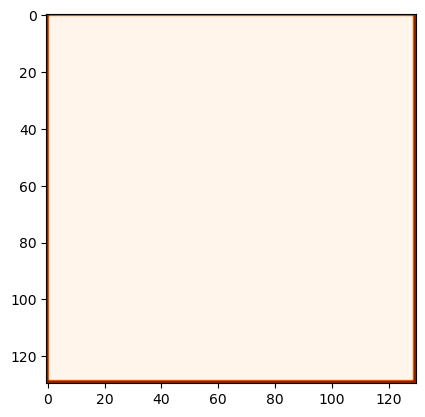

In [1010]:
a.plot_wall()

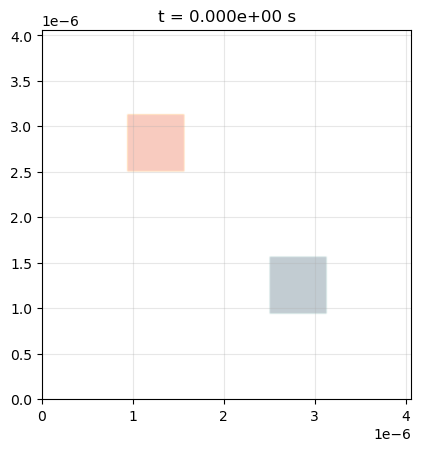

In [1011]:
a.plot_type_count(['A', 'B'])

In [1012]:
a.true_sides

array([130, 130])

In [1013]:
a.determine_maximum_timestep()

Max time step is 1.50e-03 s (max 2.0 particles in voxel)


0.001497795245398773

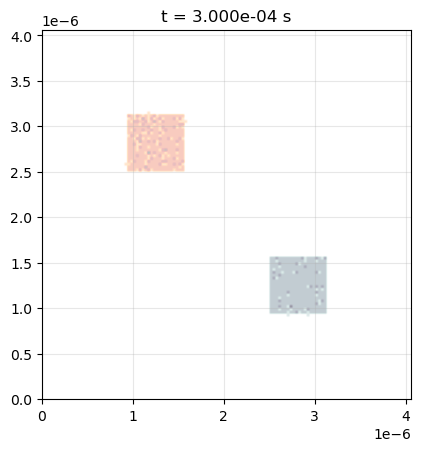

In [1014]:
a.react_diffuse(3e-4)
a.plot_type_count(['A', 'B'])

Simulate 20000 steps
200 400 600 800 1000 1200 1400 1600 1800 2000 2.73 s - 1.37 ms / step
2200 2400 2600 2800 3000 3200 3400 3600 3800 4000 5.43 s - 1.36 ms / step
4200 4400 4600 4800 5000 5200 5400 5600 5800 6000 8.13 s - 1.35 ms / step
6200 6400 6600 6800 7000 7200 7400 7600 7800 8000 10.84 s - 1.35 ms / step
8200 8400 8600 8800 9000 9200 9400 9600 9800 10000 13.54 s - 1.35 ms / step
10200 10400 10600 10800 11000 11200 11400 11600 11800 12000 16.24 s - 1.35 ms / step
12200 12400 12600 12800 13000 13200 13400 13600 13800 14000 18.94 s - 1.35 ms / step
14200 14400 14600 14800 15000 15200 15400 15600 15800 16000 21.66 s - 1.35 ms / step
16200 16400 16600 16800 17000 17200 17400 17600 17800 18000 24.39 s - 1.35 ms / step
18200 18400 18600 18800 19000 19200 19400 19600 19800 

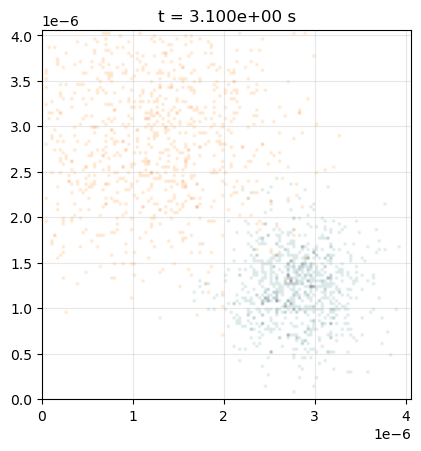

In [1019]:
a.simulate(20000, t_step=1e-4, show=False, timing=True)
a.plot_type_count(['A', 'B'])

In [971]:
r = ReactionSet()

In [26]:
r.reaction_set

{frozenset({'A', 'B'}): 3.5e-05}

In [29]:
r.reaction_set[frozenset(['A','B'])]

3.5e-05

2